# DES - simmer.R
## Optimizacija broja djelatnika u klinici sa svrhom smanjenja redova čekanja

In [12]:
options(warn=-1)

library(ggplot2)
library(simmer)
library(simmer.plot)
library(parallel)
library(grid)
library(gridExtra)

### Trenutno stanje 

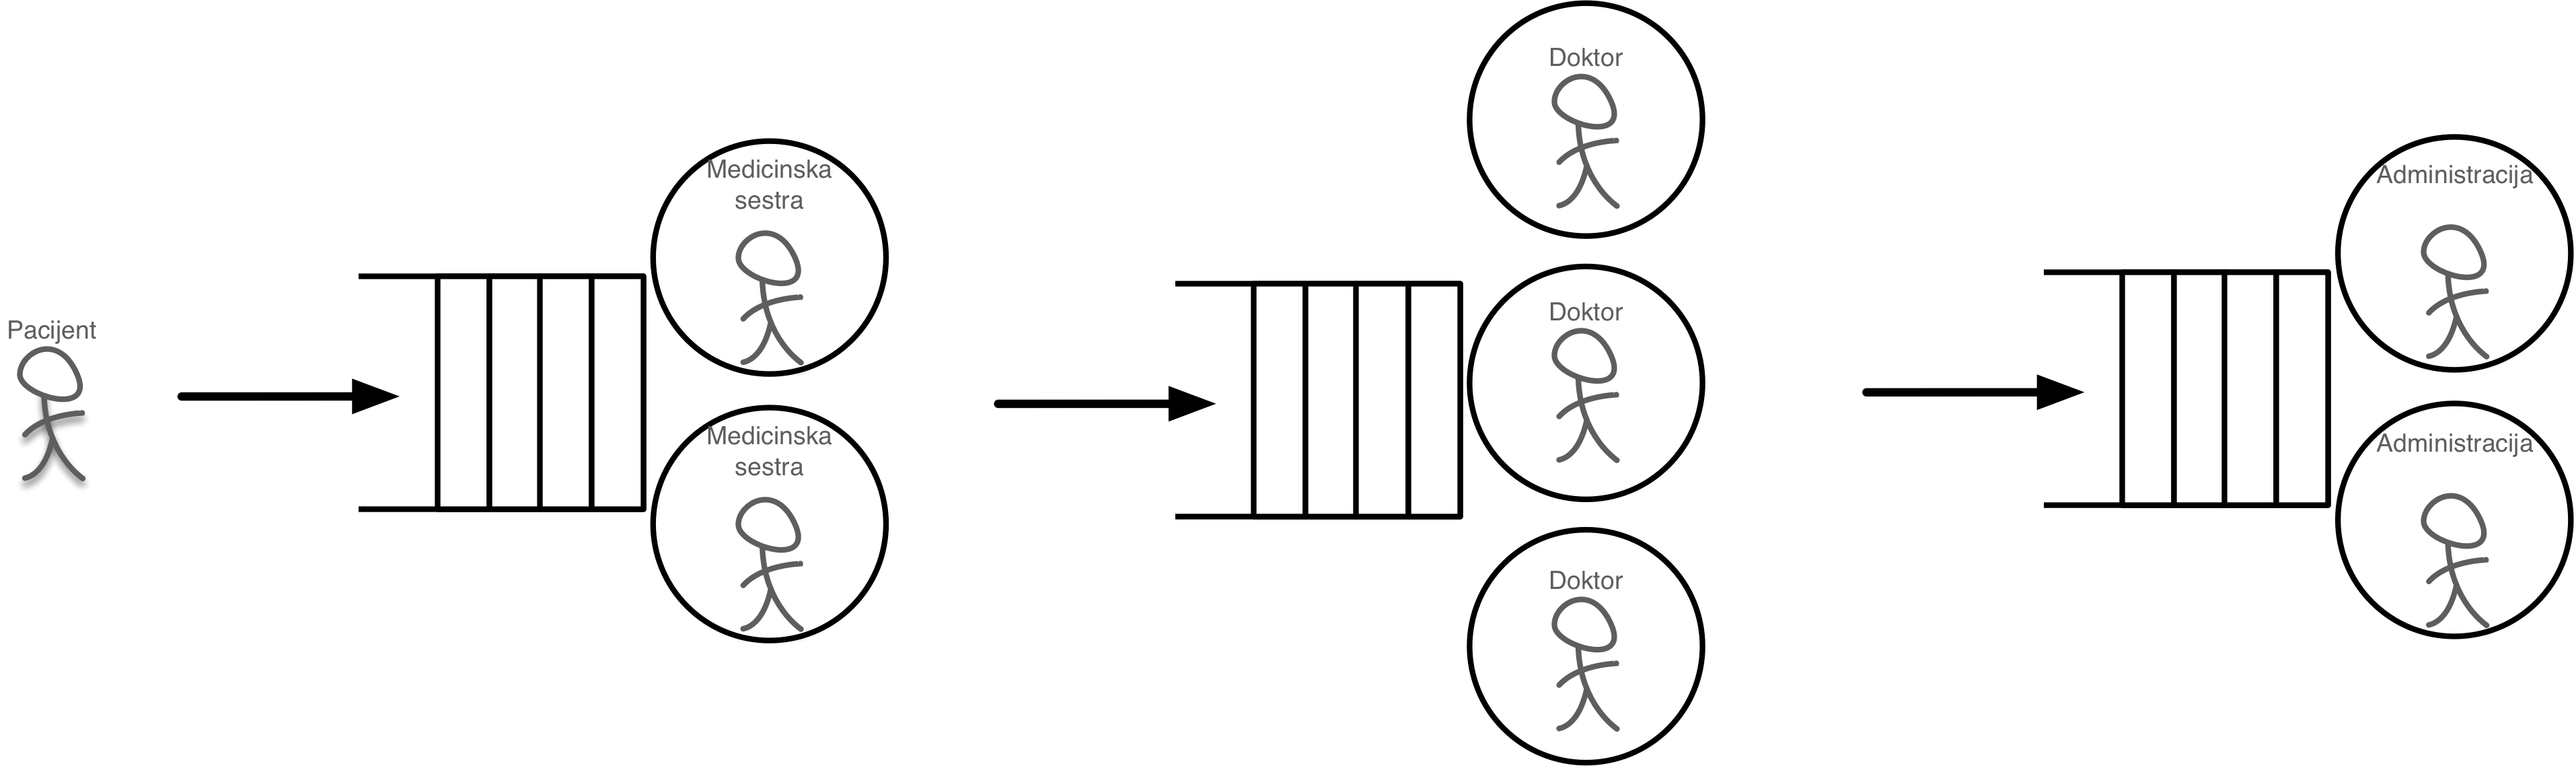

In [3]:
library("IRdisplay")
display_png(file="pacijent_stanje.png", width=700)

### Definiranje modela procesa obrade pacijenta u klinici 

In [4]:

patient <-
  trajectory("Patients' path") %>%
  
  seize("nurse", 1) %>%                  # pacijent vidi jednu sestru
  timeout(function() rnorm(1, 15)) %>%   # 15 minuta prosjek
  release("nurse", 1) %>%

  seize("doctor", 1) %>%
  timeout(function() rnorm(1, 20)) %>%
  release("doctor", 1) %>%
  
  seize("administration", 1) %>%
  timeout(function() rnorm(1, 5)) %>%
  release("administration", 1)


### Simulacija rada klinike

#### izvođenje simulacije 540 minuta (9 sati)

simmer environment: clinic | now: 540 | next: 542.154702603931
{ Monitor: in memory }
{ Resource: nurse | monitored: TRUE | server status: 2(2) | queue status: 35(Inf) }
{ Resource: doctor | monitored: TRUE | server status: 3(3) | queue status: 0(Inf) }
{ Resource: administration | monitored: TRUE | server status: 0(2) | queue status: 0(Inf) }
{ Source: patient | monitored: 1 | n_generated: 108 }

name,start_time,end_time,activity_time,finished,replication
patient0,5.928873,45.03654,39.10767,TRUE,1
patient1,11.433075,52.83576,41.40268,TRUE,1
patient2,17.140325,58.32008,39.91211,TRUE,1
patient3,22.512537,67.71772,40.33111,TRUE,1
patient4,28.156901,75.88711,42.83164,TRUE,1
patient5,32.600651,79.56599,38.80632,TRUE,1


resource,time,server,queue,capacity,queue_size,system,limit,replication
nurse,5.928873,1,0,2,Inf,1,Inf,1
nurse,11.433075,2,0,2,Inf,2,Inf,1
nurse,17.140325,2,1,2,Inf,3,Inf,1
nurse,18.407971,2,0,2,Inf,2,Inf,1
doctor,18.407971,1,0,3,Inf,1,Inf,1
nurse,22.512537,2,1,2,Inf,3,Inf,1


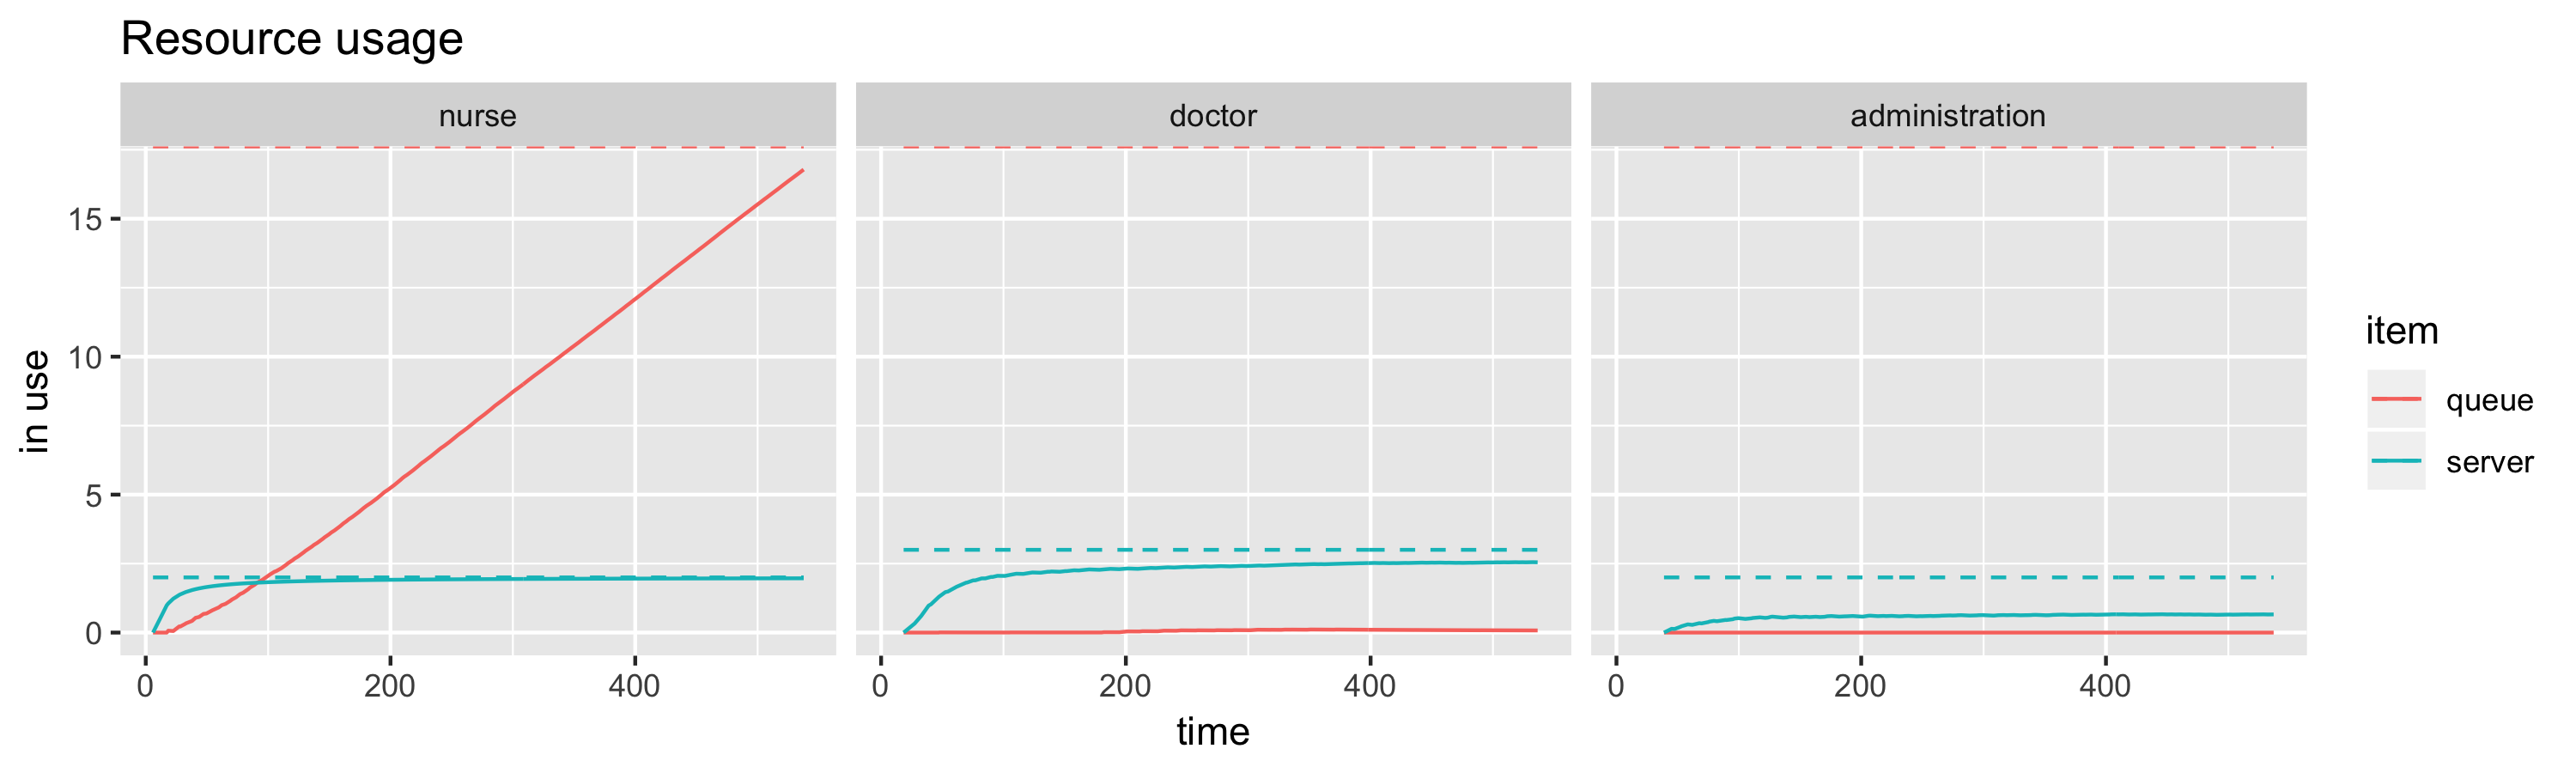

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


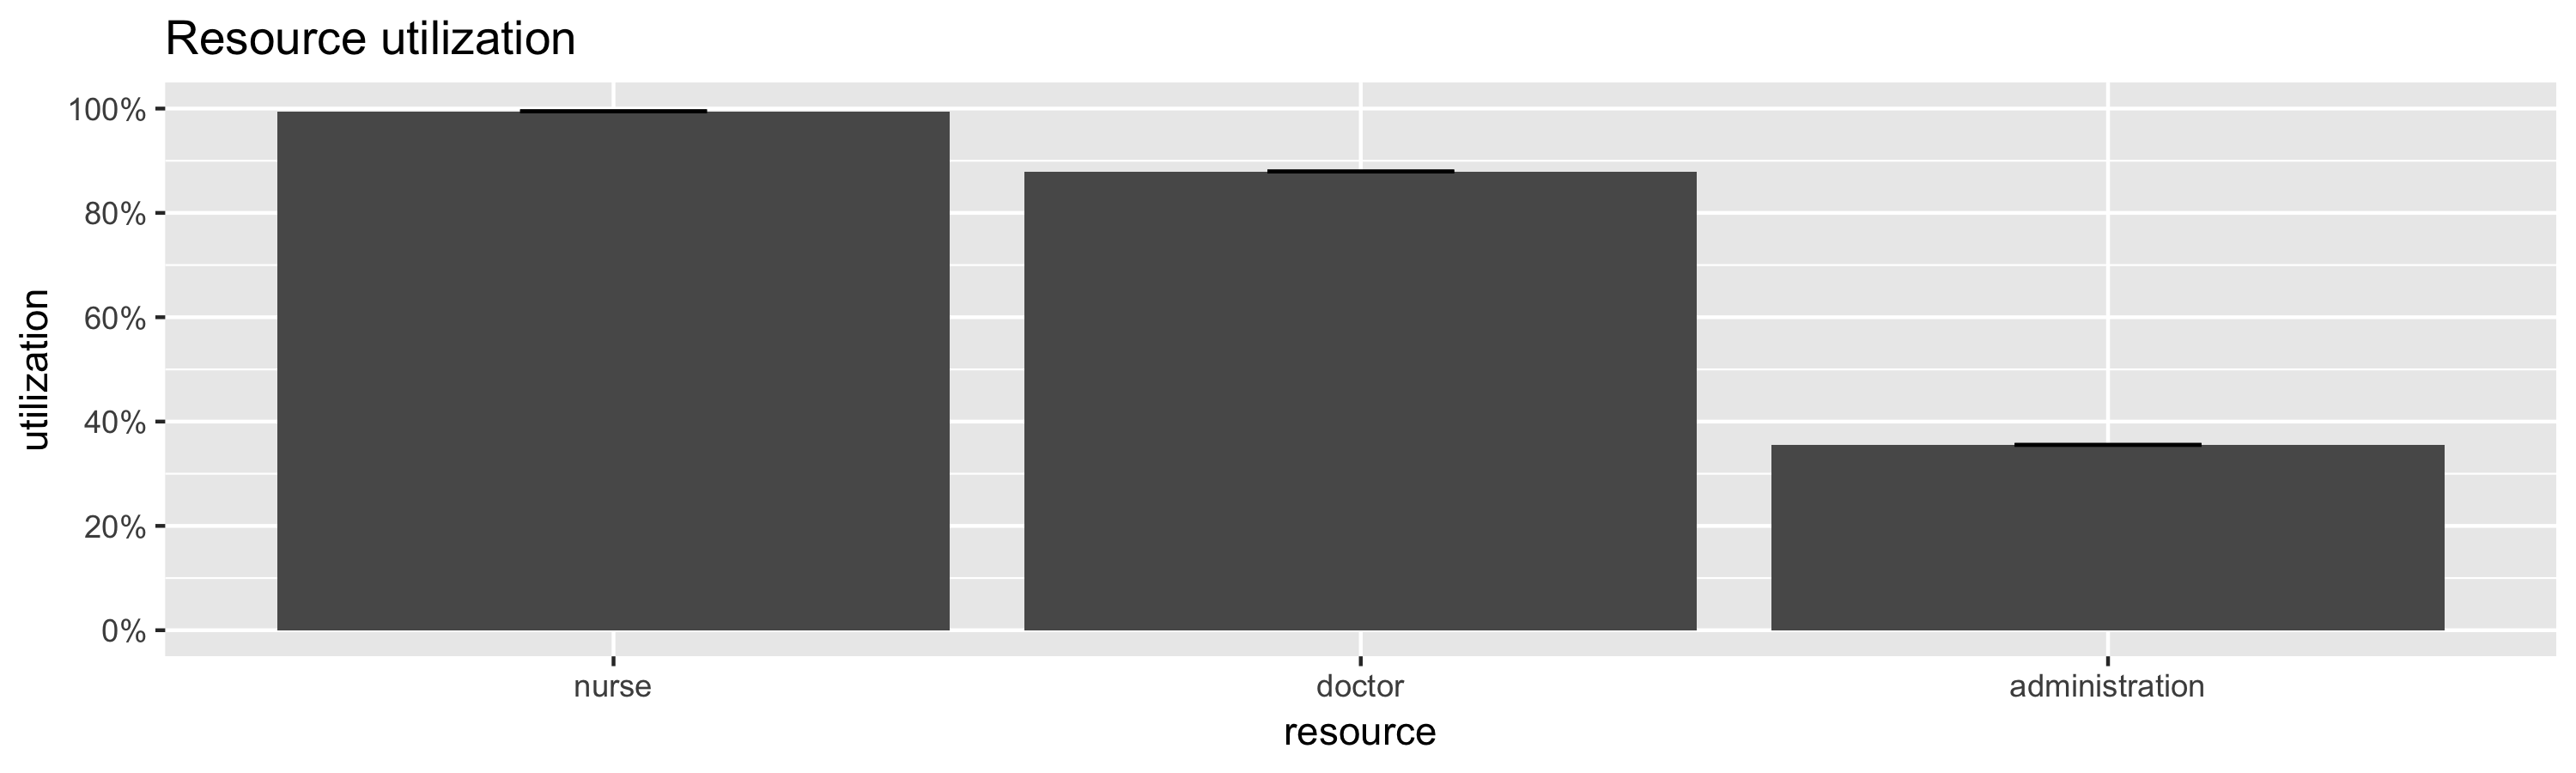

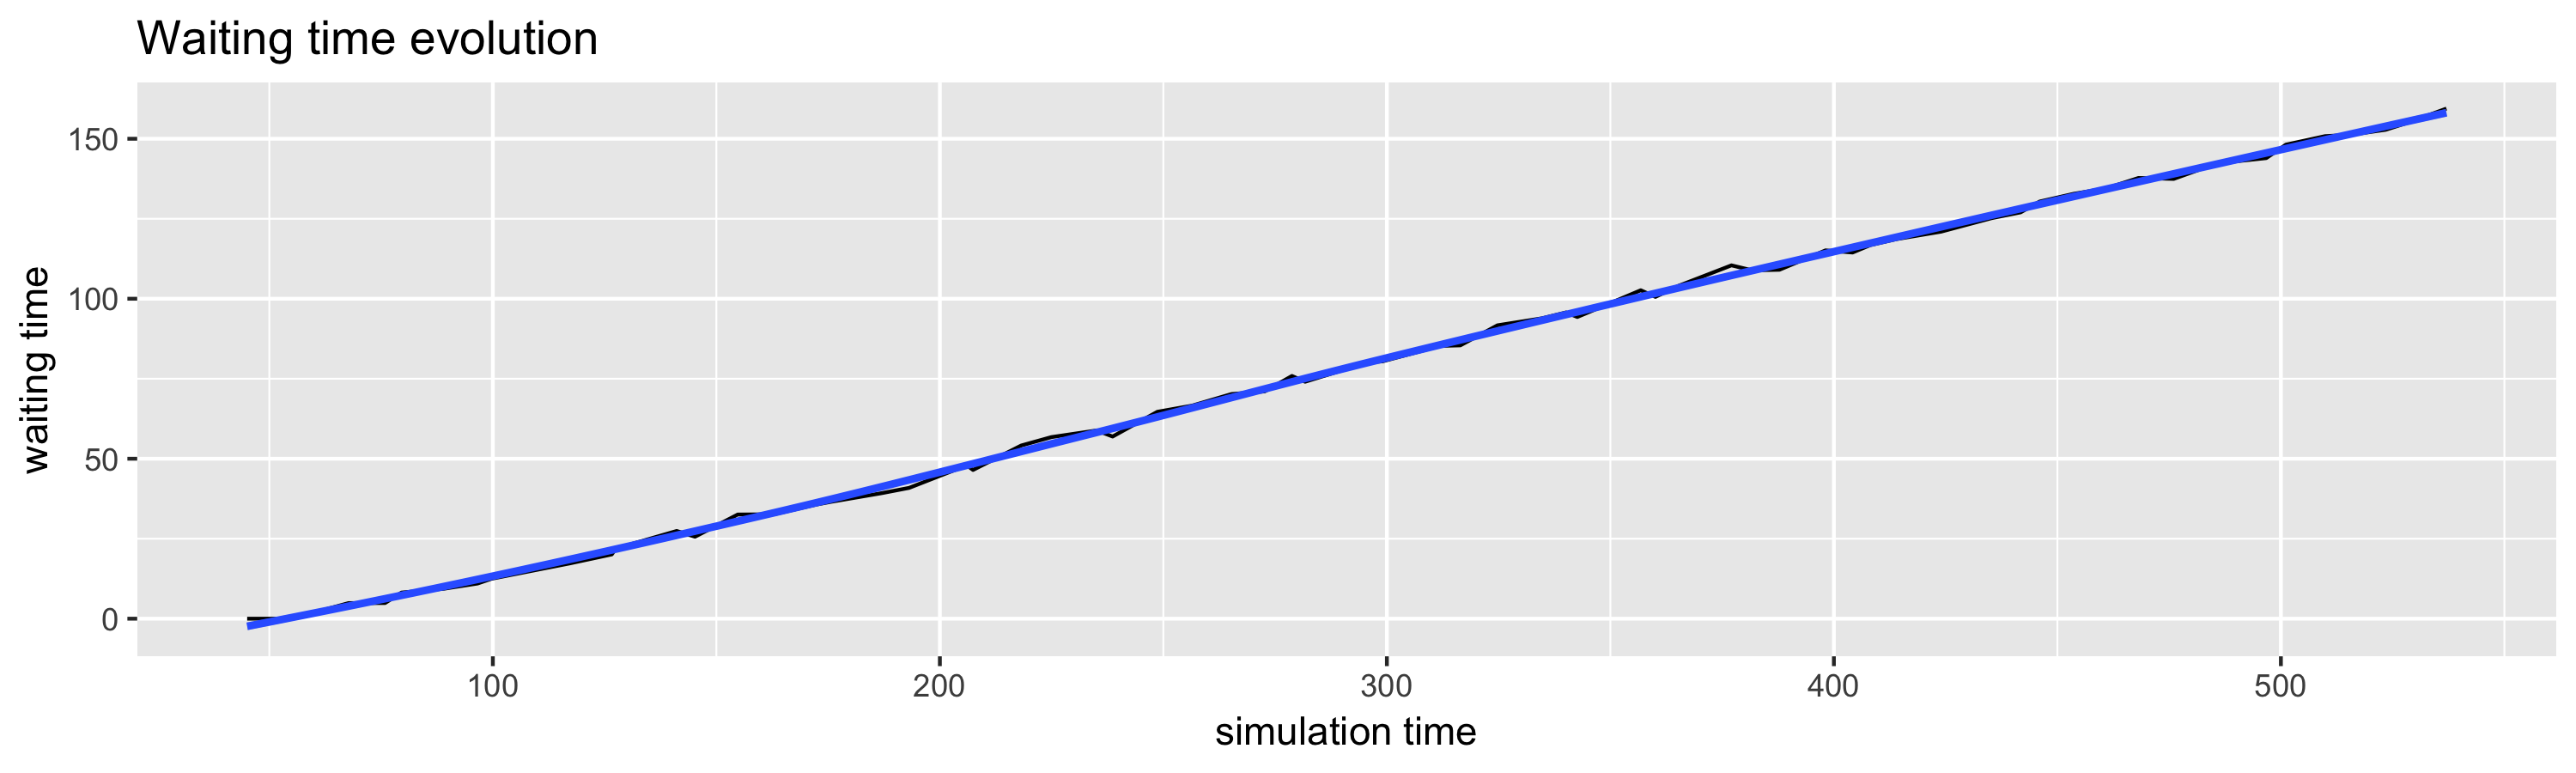

In [8]:

env1 <- simmer("clinic")

env1 %>%
  add_resource("nurse", 2) %>%
  add_resource("doctor", 3) %>%
  add_resource("administration", 2) %>%
  add_generator("patient", patient, function() rnorm(1, 5, 0.5)) %>%  # 5 minuta
  run(until=540)   # izvođenje simulacije 540 minuta; 9 sati

options(repr.plot.width=10, repr.plot.height=3, repr.plot.res=300)
par(mfrow=c(1,2))
                
                
env1_arrivals <- get_mon_arrivals(env1)
env1_resources <- get_mon_resources(env1)

head(env1_arrivals)
head(env1_resources)


plot(env1_resources, metric = "usage", c("nurse", "doctor", "administration"),
     items=c("queue", "server"))

plot(env1_resources, metric="utilization", c("nurse", "doctor", "administration"))

plot(env1_arrivals, metric = "waiting_time")


### ANALIZA REZULTATA SIMULACIJE

prosječno 110 pacijenata dnevno


klinika otvorena od 8 do 17 sati


vrijeme čekanja pacijenata je dugo


#### Pronalaženje rješenja za ovaj problem:
1. pregled procesa tijeka rada (workflow)
2. prikupljanje podataka o dolascima (Arrivals) i usluzi (Service)
3. kreiranje modela procesa i validacija
4. izvođenje simulacije s različitim parametrima
5. analiza rezultata
6. preporuke sustavu

### CILJEVI SIMULACIJE

1. smanjiti listu čekanja na < 2 pacijenta
2. smanjiti vrijeme čekanja na < 5 minuta

#### zapošljavanje dodatne medicinske sestre

simmer environment: clinic | now: 540 | next: 540.993920579035
{ Monitor: in memory }
{ Resource: nurse | monitored: TRUE | server status: 3(3) | queue status: 1(Inf) }
{ Resource: doctor | monitored: TRUE | server status: 3(3) | queue status: 24(Inf) }
{ Resource: administration | monitored: TRUE | server status: 2(2) | queue status: 0(Inf) }
{ Source: patient | monitored: 1 | n_generated: 108 }

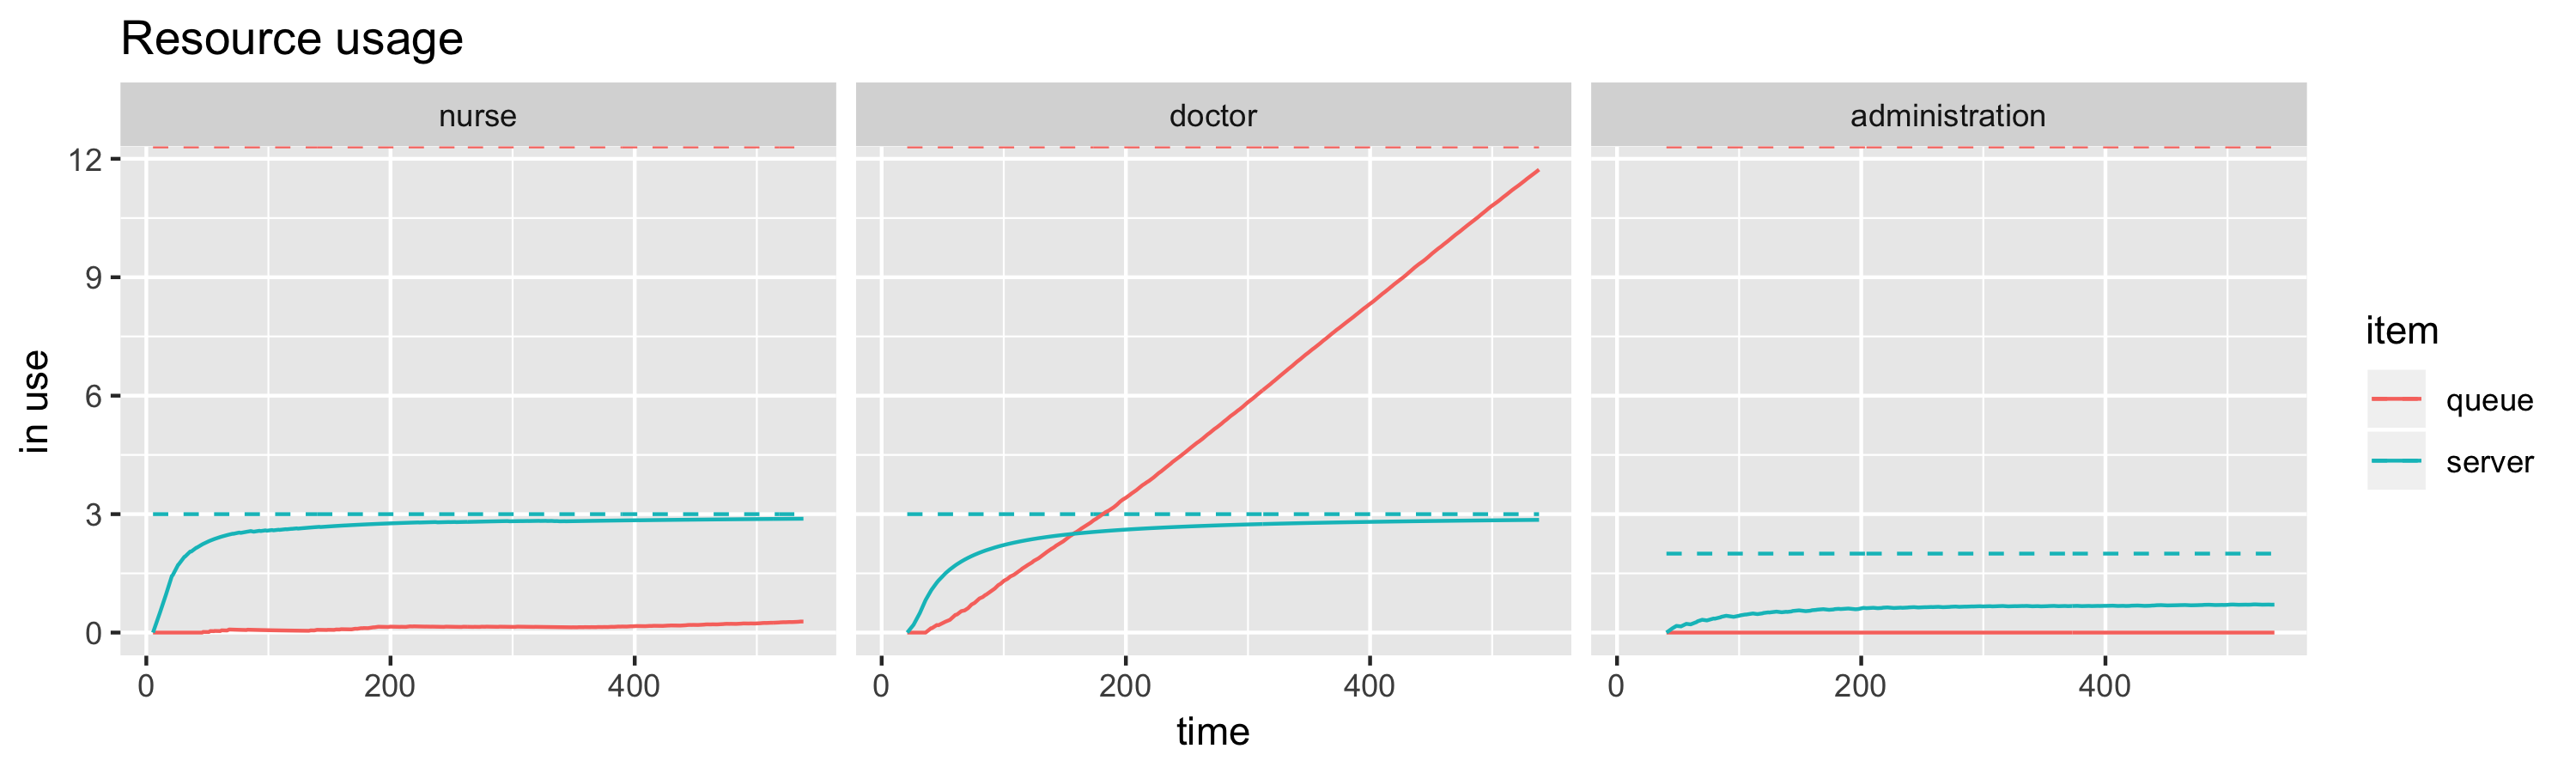

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


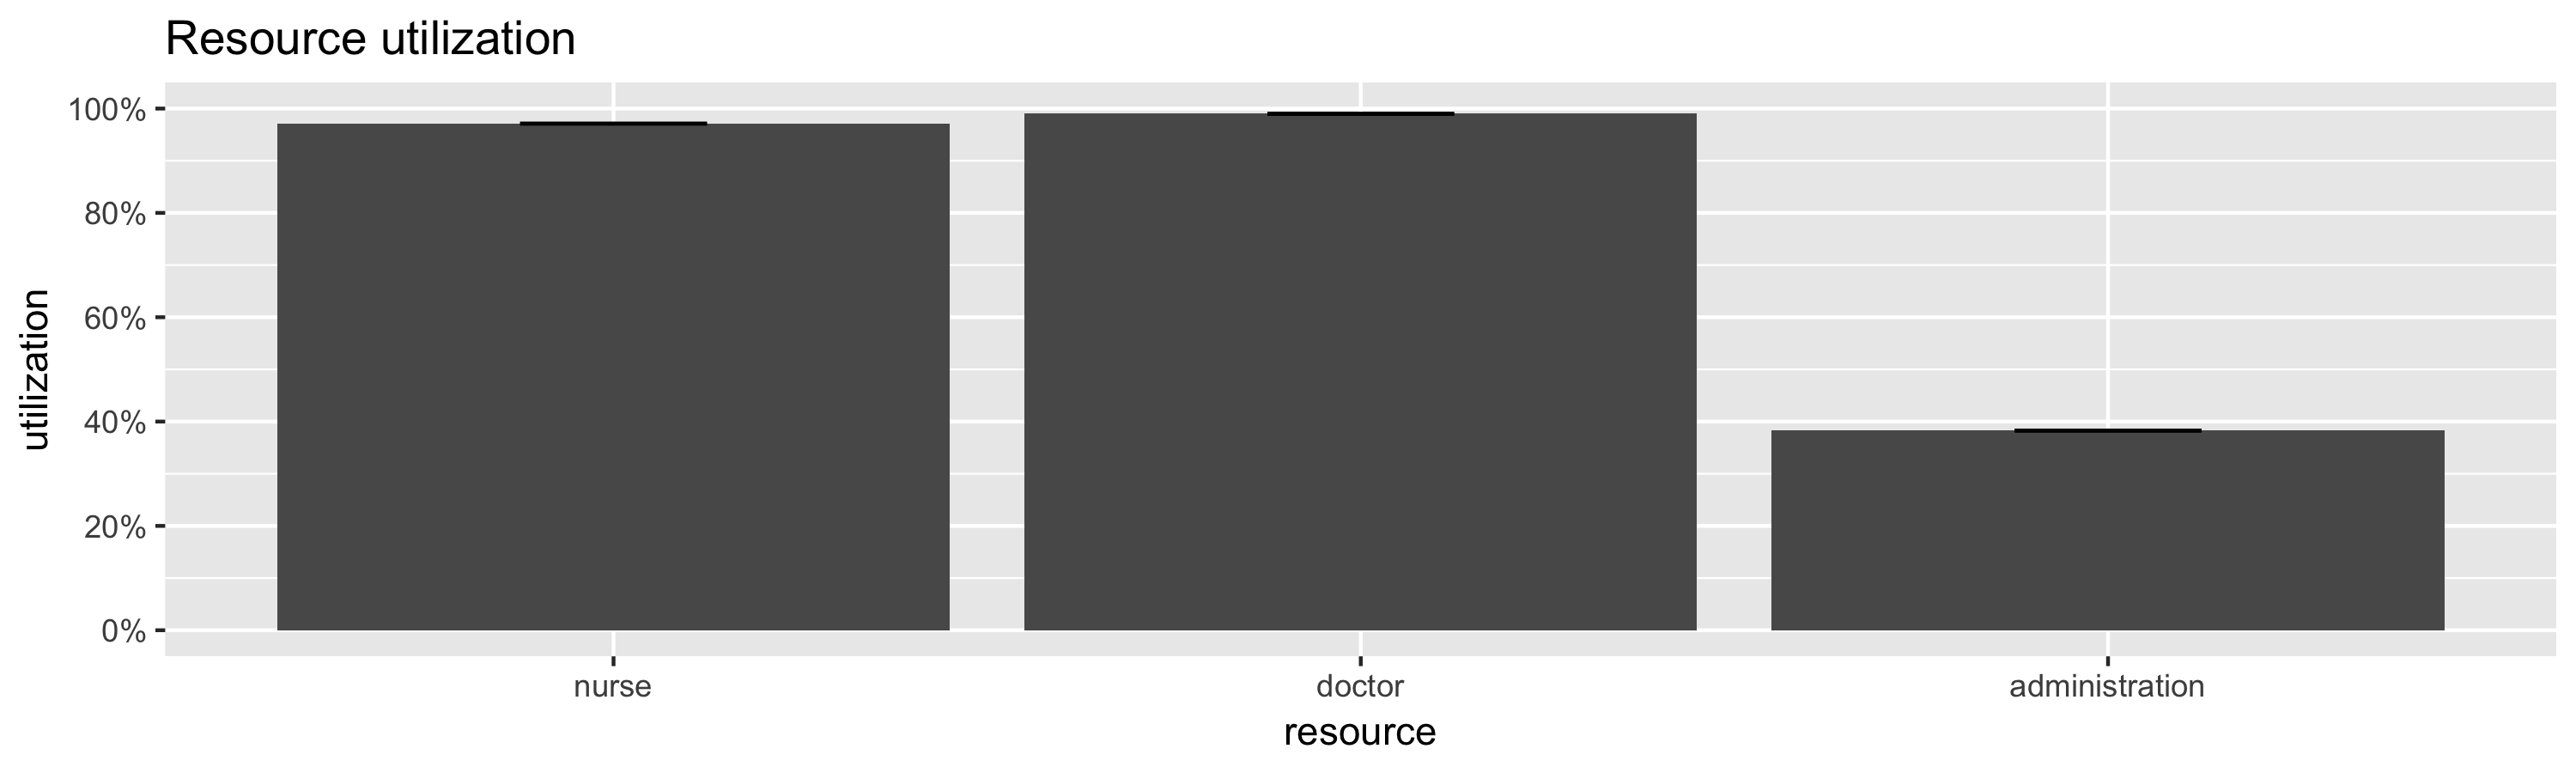

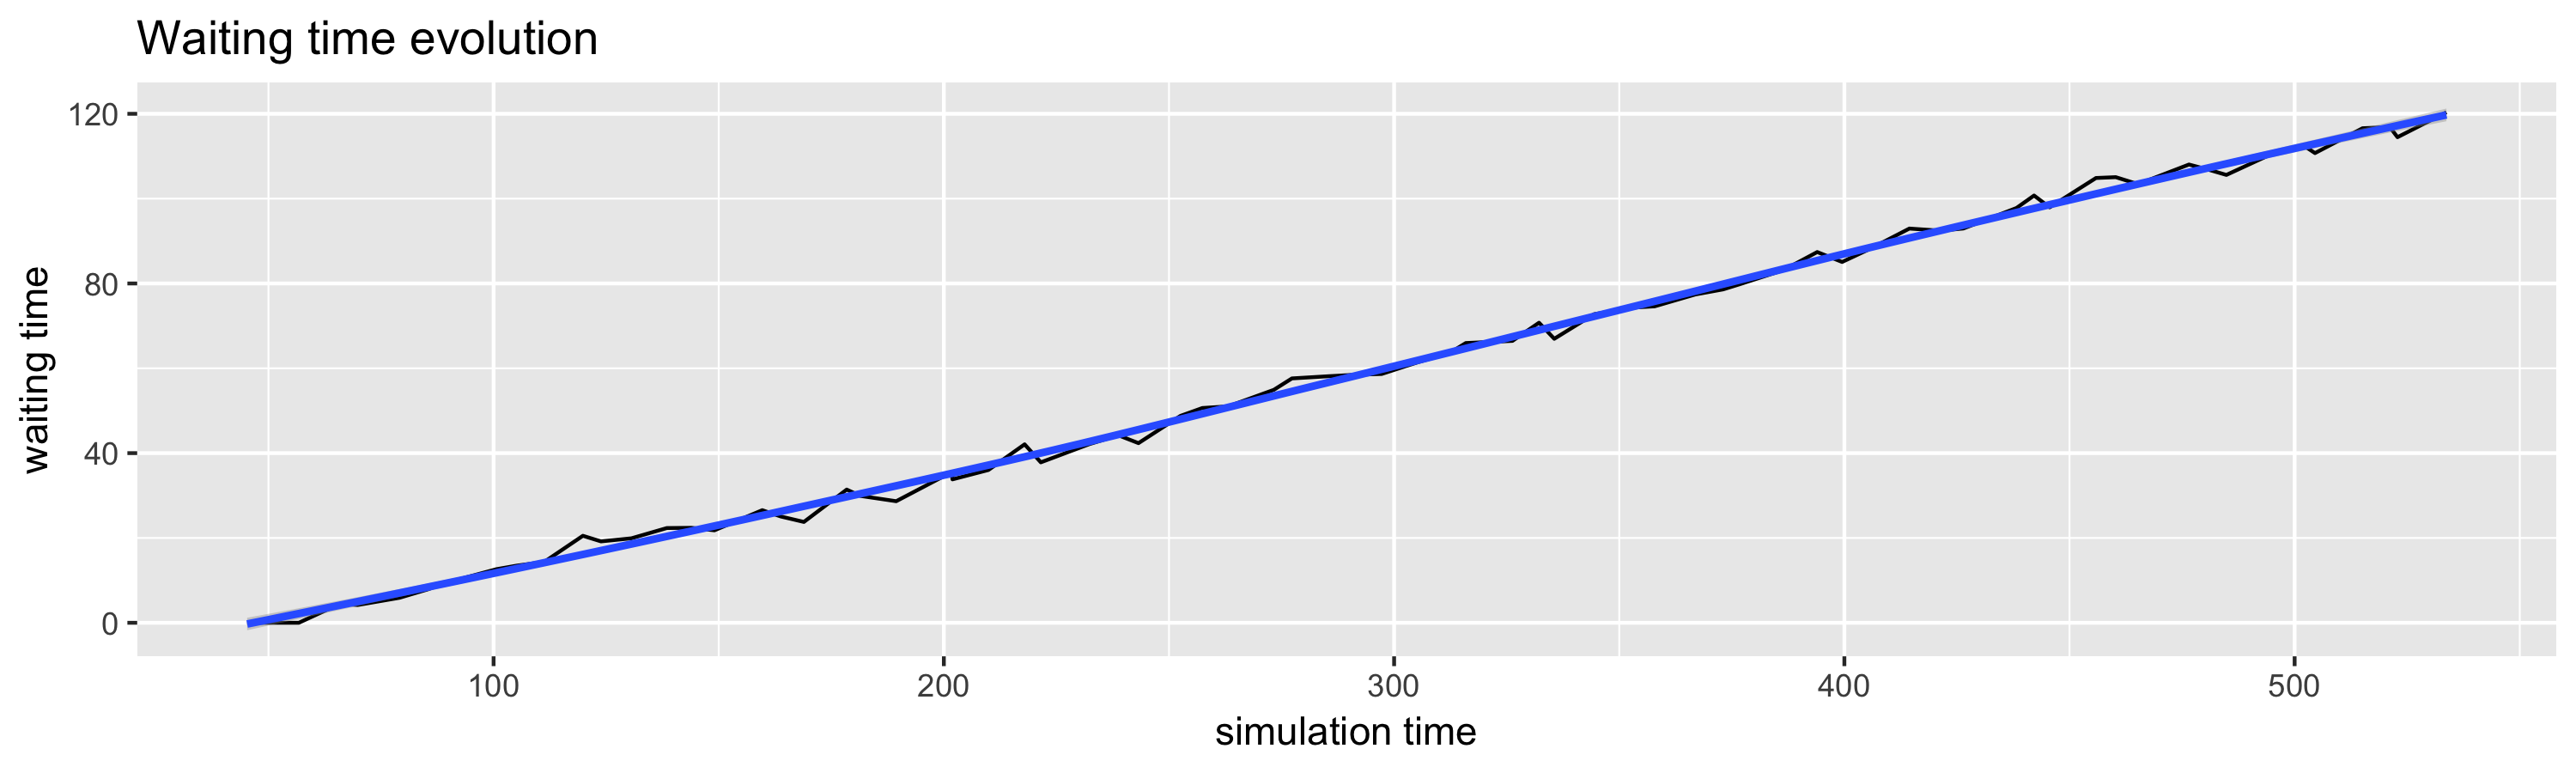

In [9]:

env2 <- simmer("clinic")

env2 %>%
  add_resource("nurse", 3) %>%    # DODALI SMO MED. SESTRU
  add_resource("doctor", 3) %>%
  add_resource("administration", 2) %>%
  add_generator("patient", patient, function() rnorm(1, 5, 0.5)) %>%
  run(until=540)  # 540 minuta, 9 sati


env2_arrivals <- get_mon_arrivals(env2)
env2_resources <- get_mon_resources(env2)

plot(env2_resources, metric = "usage", c("nurse", "doctor", "administration"),
     items=c("queue", "server"))

plot(env2_resources, metric="utilization", c("nurse", "doctor", "administration"))

plot(env2_arrivals, metric = "waiting_time")

#### zapošljavanje dodatnog doktora

simmer environment: clinic | now: 540 | next: 541.140261245099
{ Monitor: in memory }
{ Resource: nurse | monitored: TRUE | server status: 3(3) | queue status: 1(Inf) }
{ Resource: doctor | monitored: TRUE | server status: 4(4) | queue status: 2(Inf) }
{ Resource: administration | monitored: TRUE | server status: 1(2) | queue status: 0(Inf) }
{ Source: patient | monitored: 1 | n_generated: 109 }

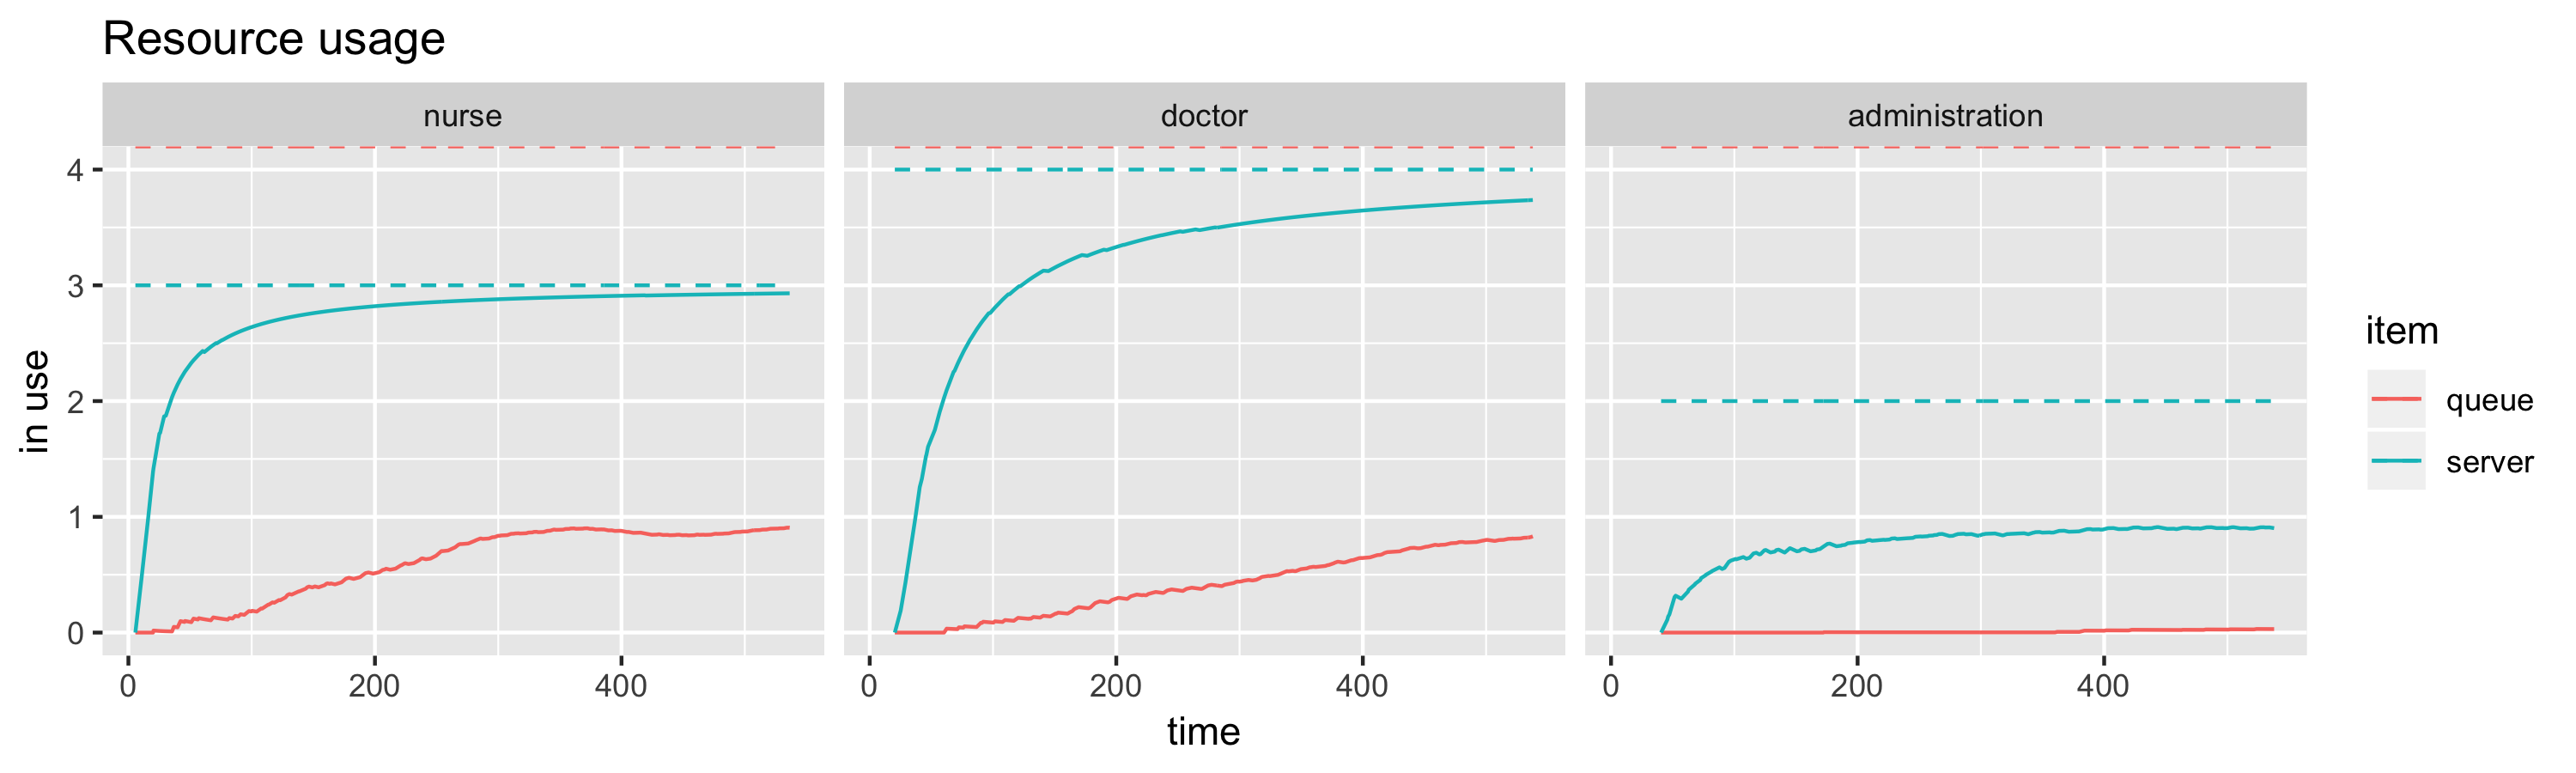

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


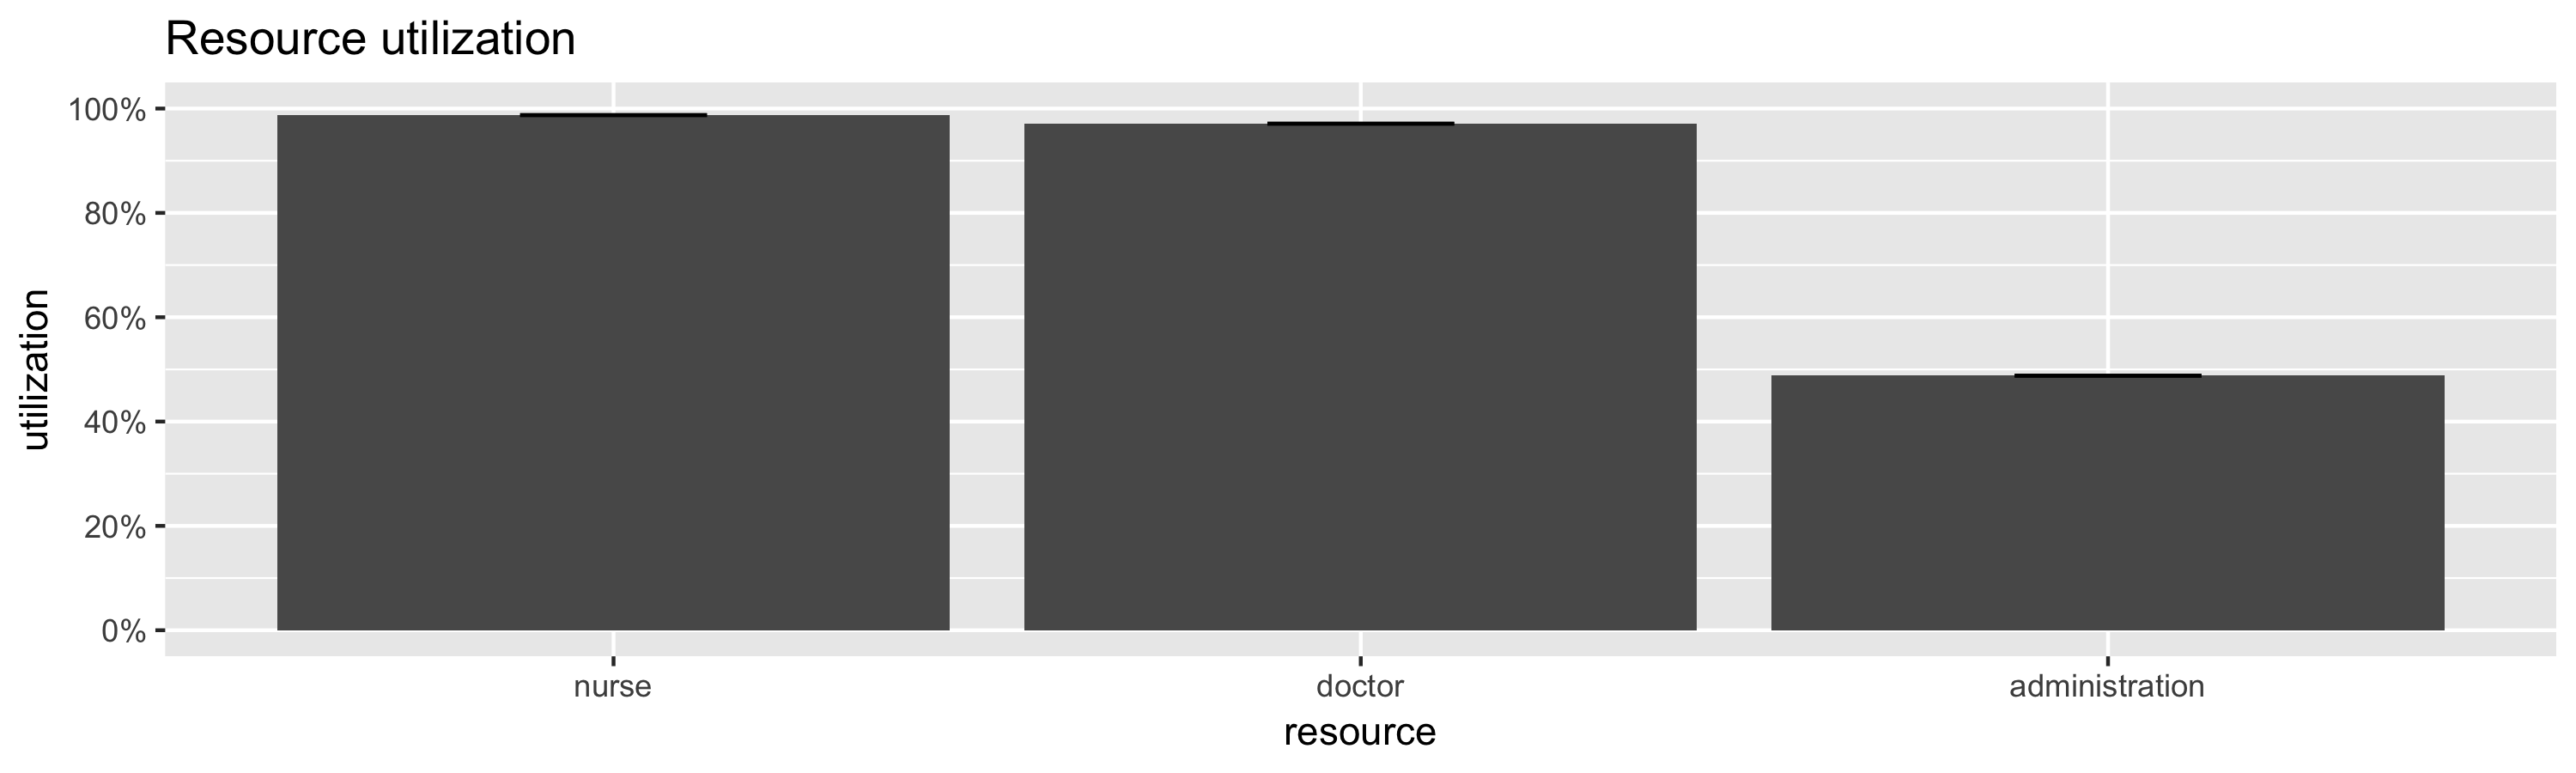

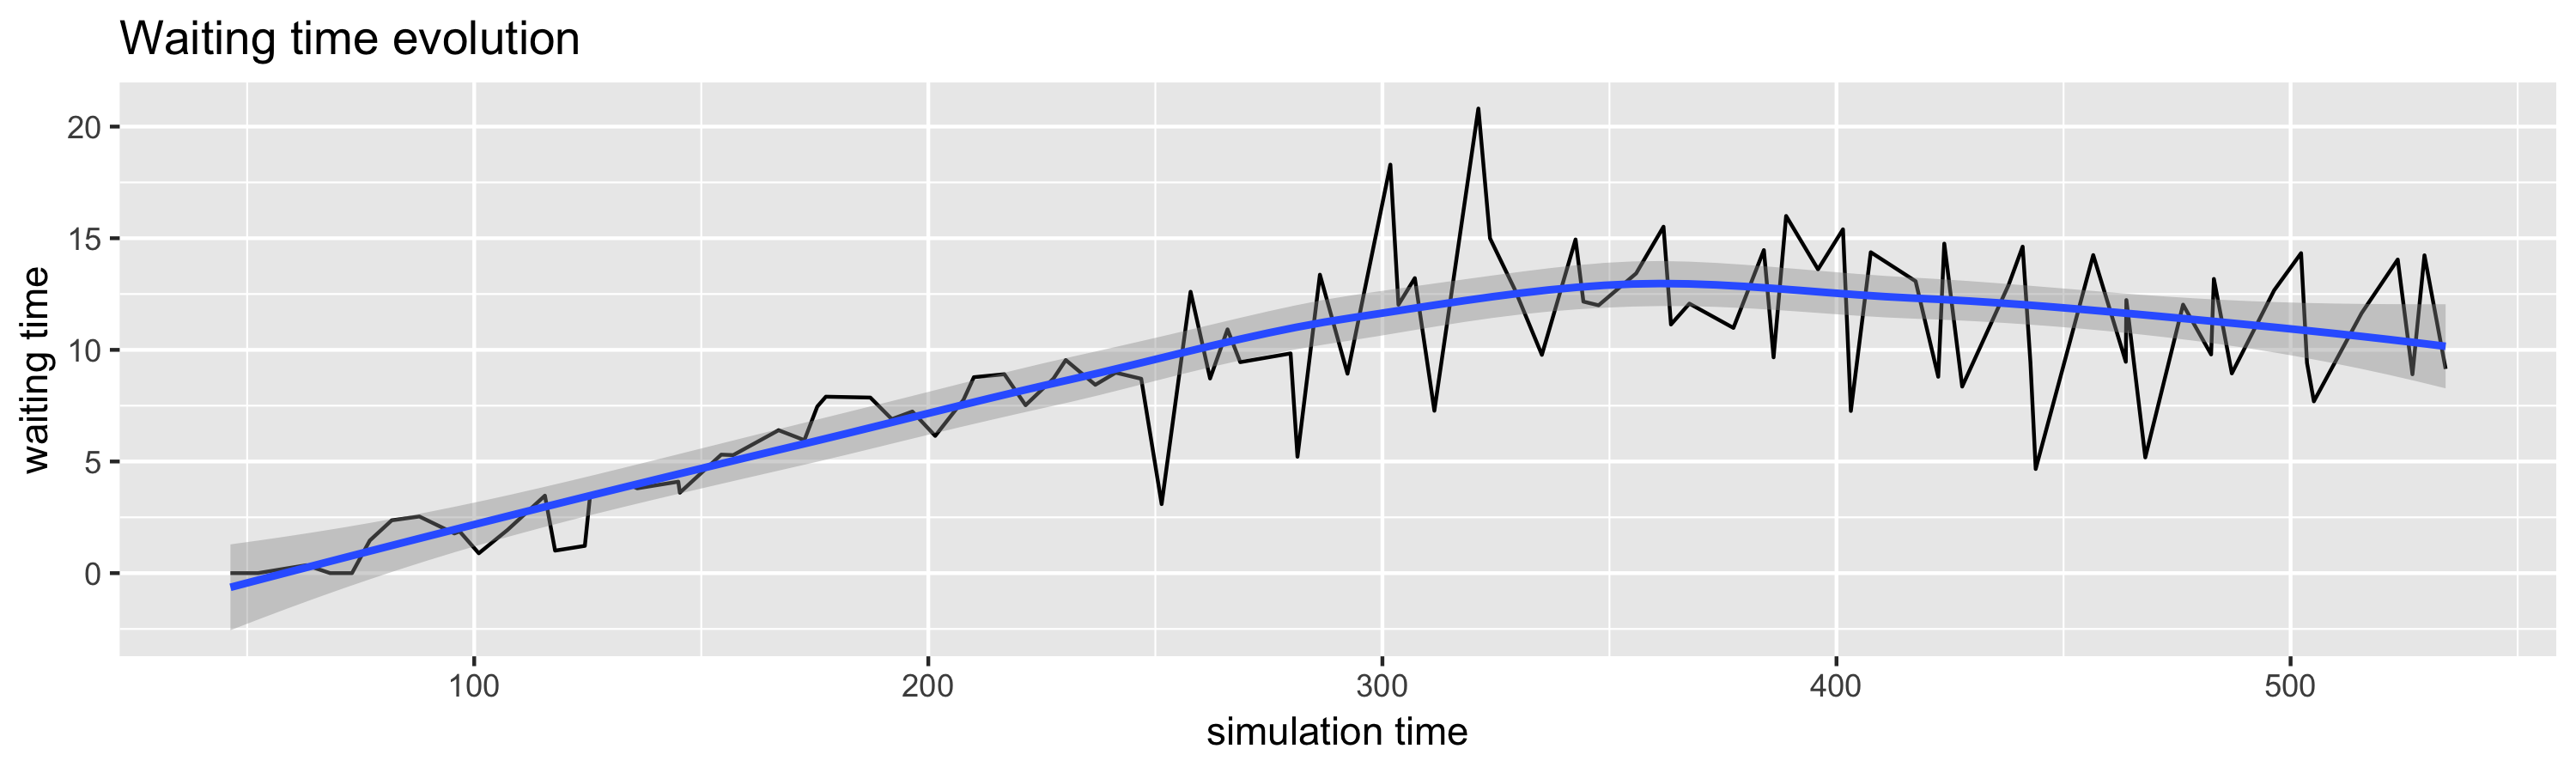

In [10]:

env3 <- simmer("clinic")

env3 %>%
  add_resource("nurse", 3) %>%    
  add_resource("doctor", 4) %>%     # DODALI SMO DOKTORA
  add_resource("administration", 2) %>%
  add_generator("patient", patient, function() rnorm(1, 5, 0.5)) %>%
  run(until=540)  # 540 minuta, 9 sati


env3_arrivals <- get_mon_arrivals(env3)
env3_resources <- get_mon_resources(env3)

plot(env3_resources, metric = "usage", c("nurse", "doctor", "administration"),
     items=c("queue", "server"))

plot(env3_resources, metric="utilization", c("nurse", "doctor", "administration"))

plot(env3_arrivals, metric = "waiting_time")



### Preporuke sustavu

dodati 1 sestru


dodati 1 doktora





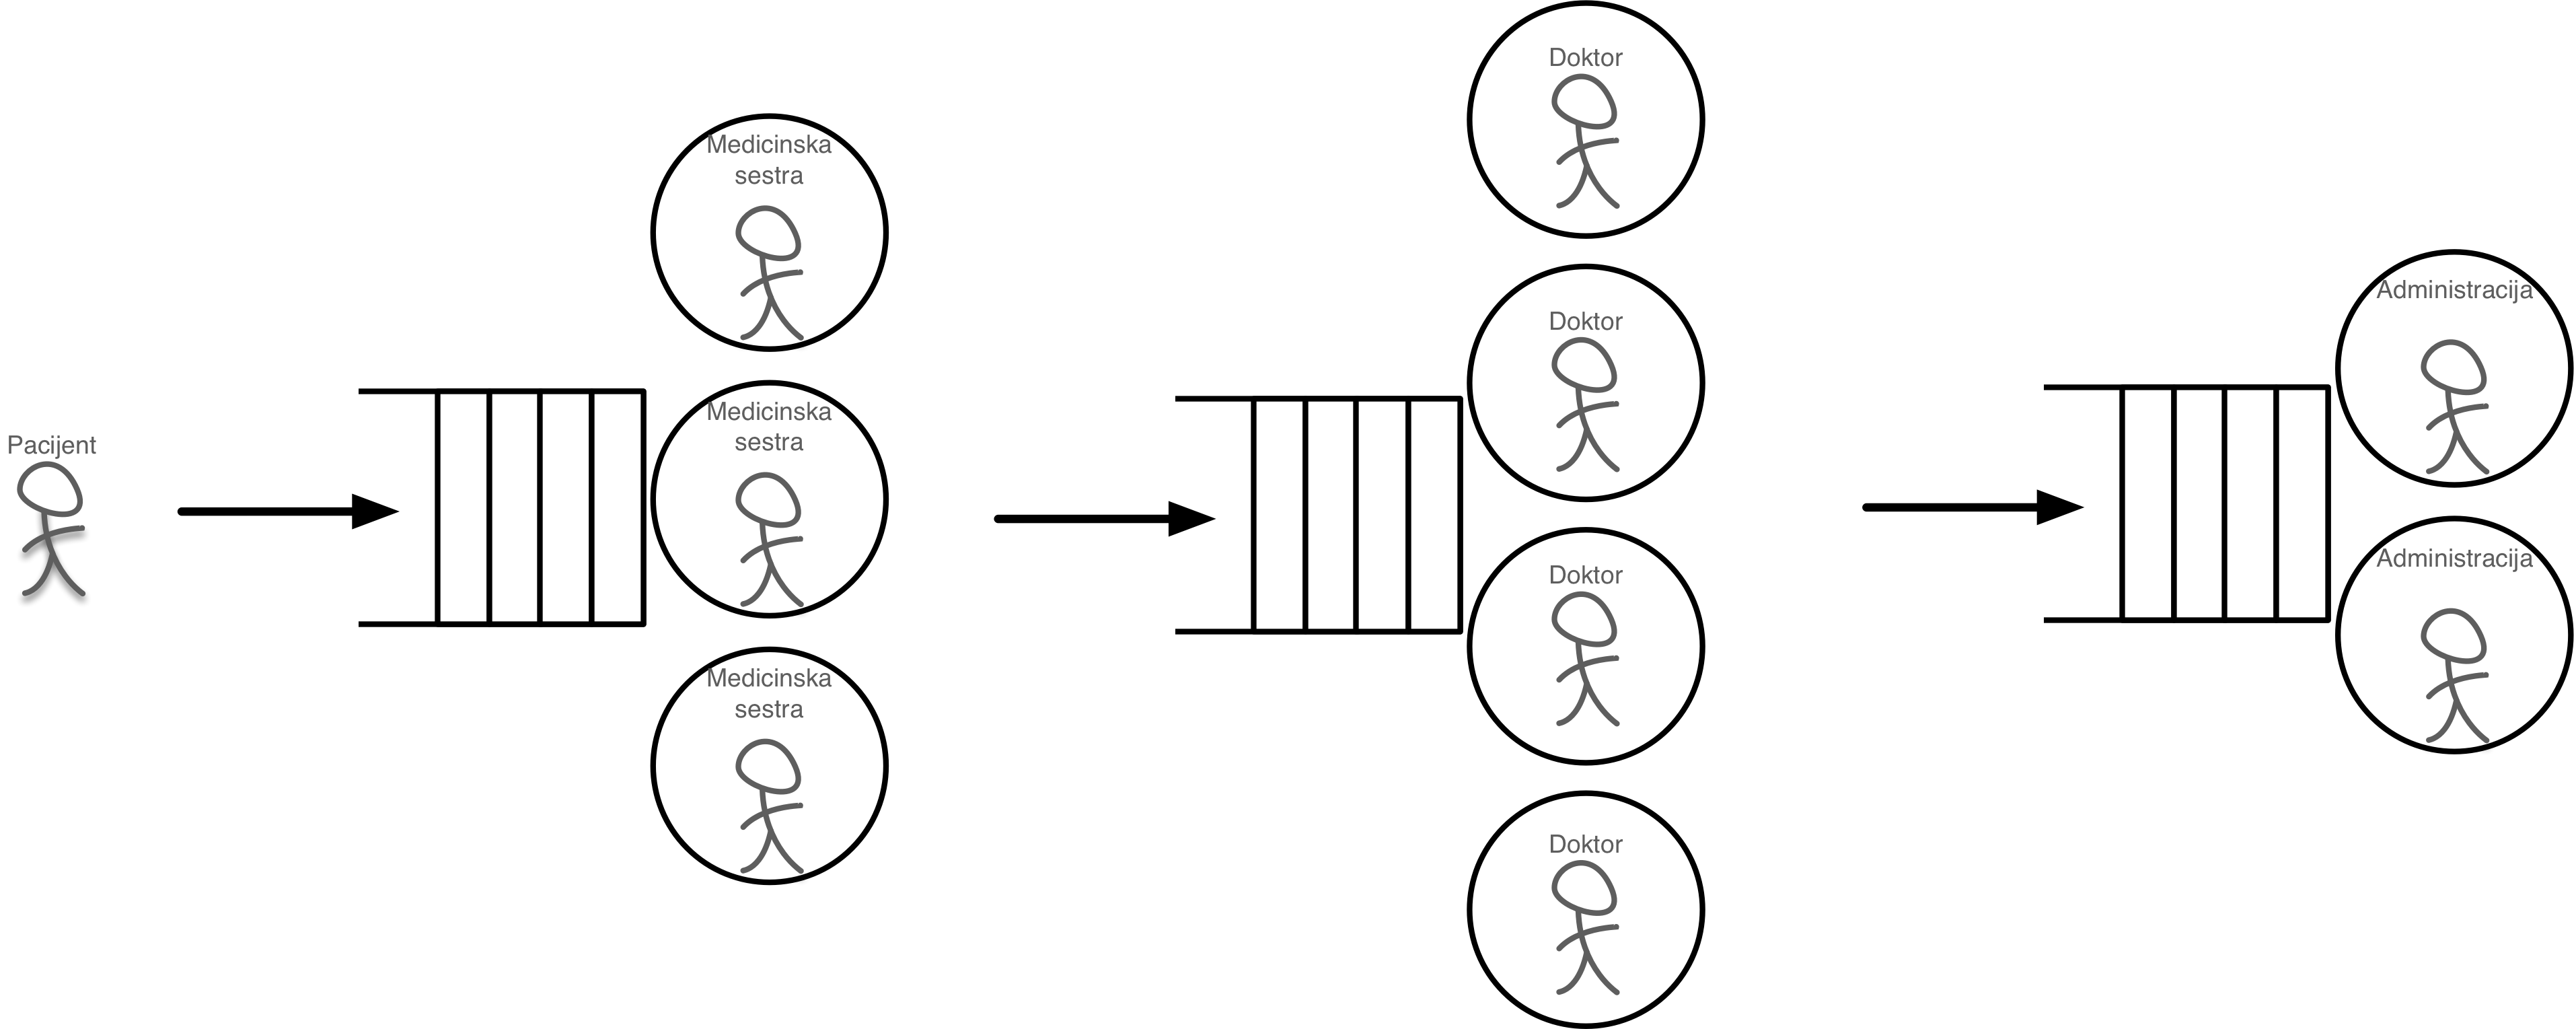

In [40]:
library("IRdisplay")
display_png(file="pacijent_preporuka.png", width=700)

### DISKUSIJA

Što će se desiti s cijenom usluge, troškovima poslovanja, prigodima, zadovoljstvom klijenata ako zaposlimo dodatnu sestru i doktora?


simmer environment: clinic | now: 540 | next: 541.52656397863
{ Monitor: in memory }
{ Resource: nurse | monitored: TRUE | server status: 3(4) | queue status: 0(Inf) }
{ Resource: doctor | monitored: TRUE | server status: 4(5) | queue status: 0(Inf) }
{ Resource: administration | monitored: TRUE | server status: 0(2) | queue status: 0(Inf) }
{ Source: patient | monitored: 1 | n_generated: 108 }

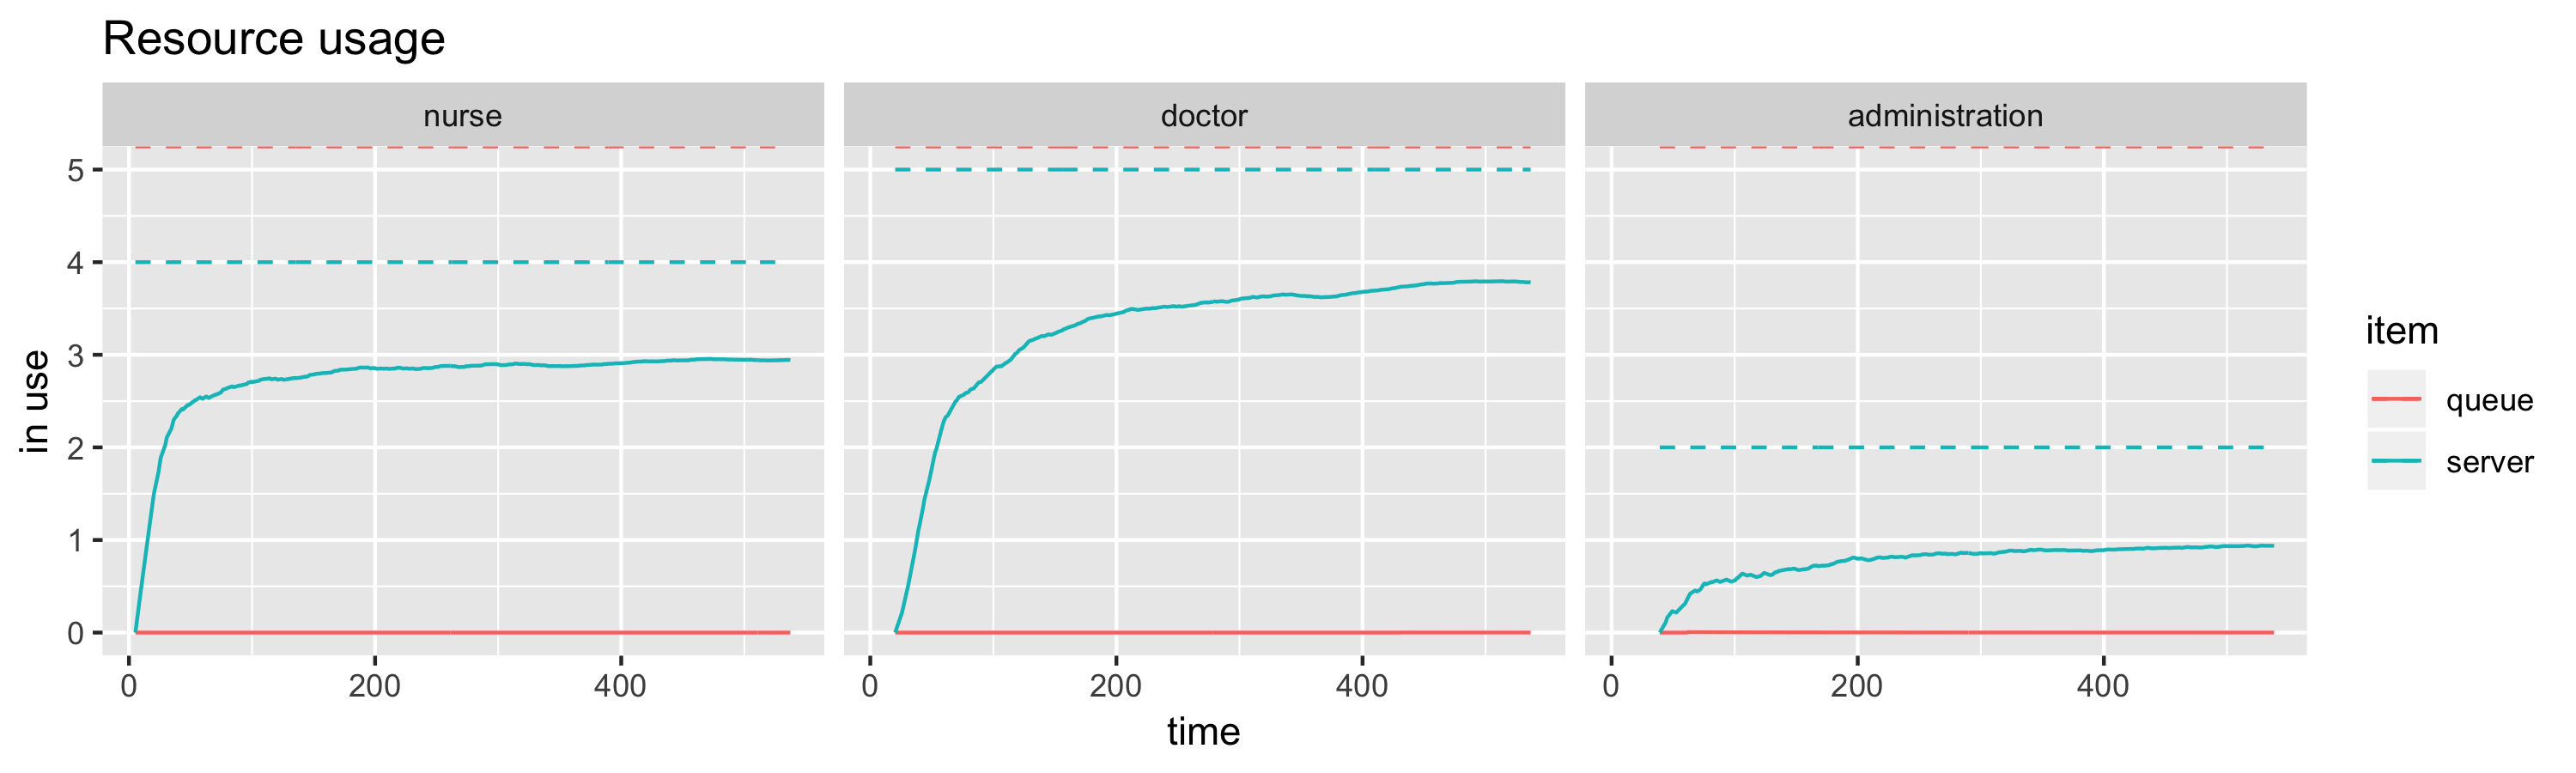

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


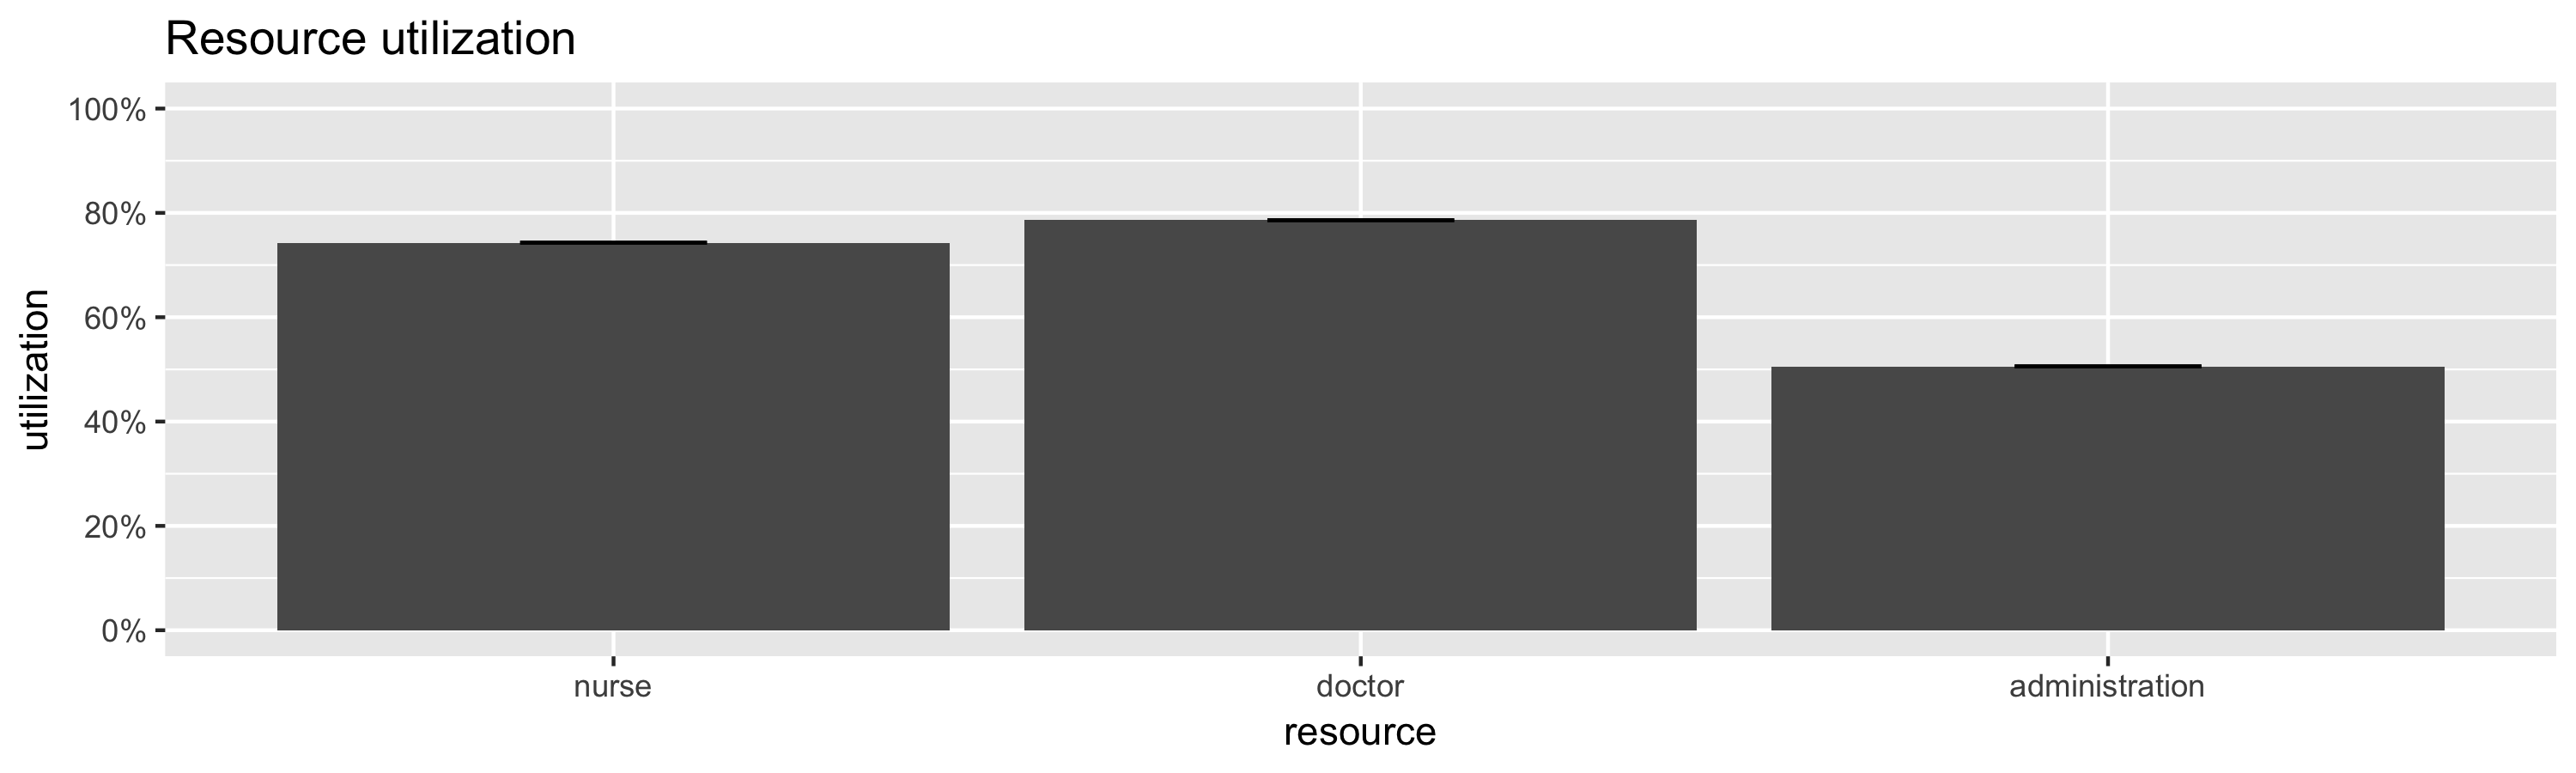

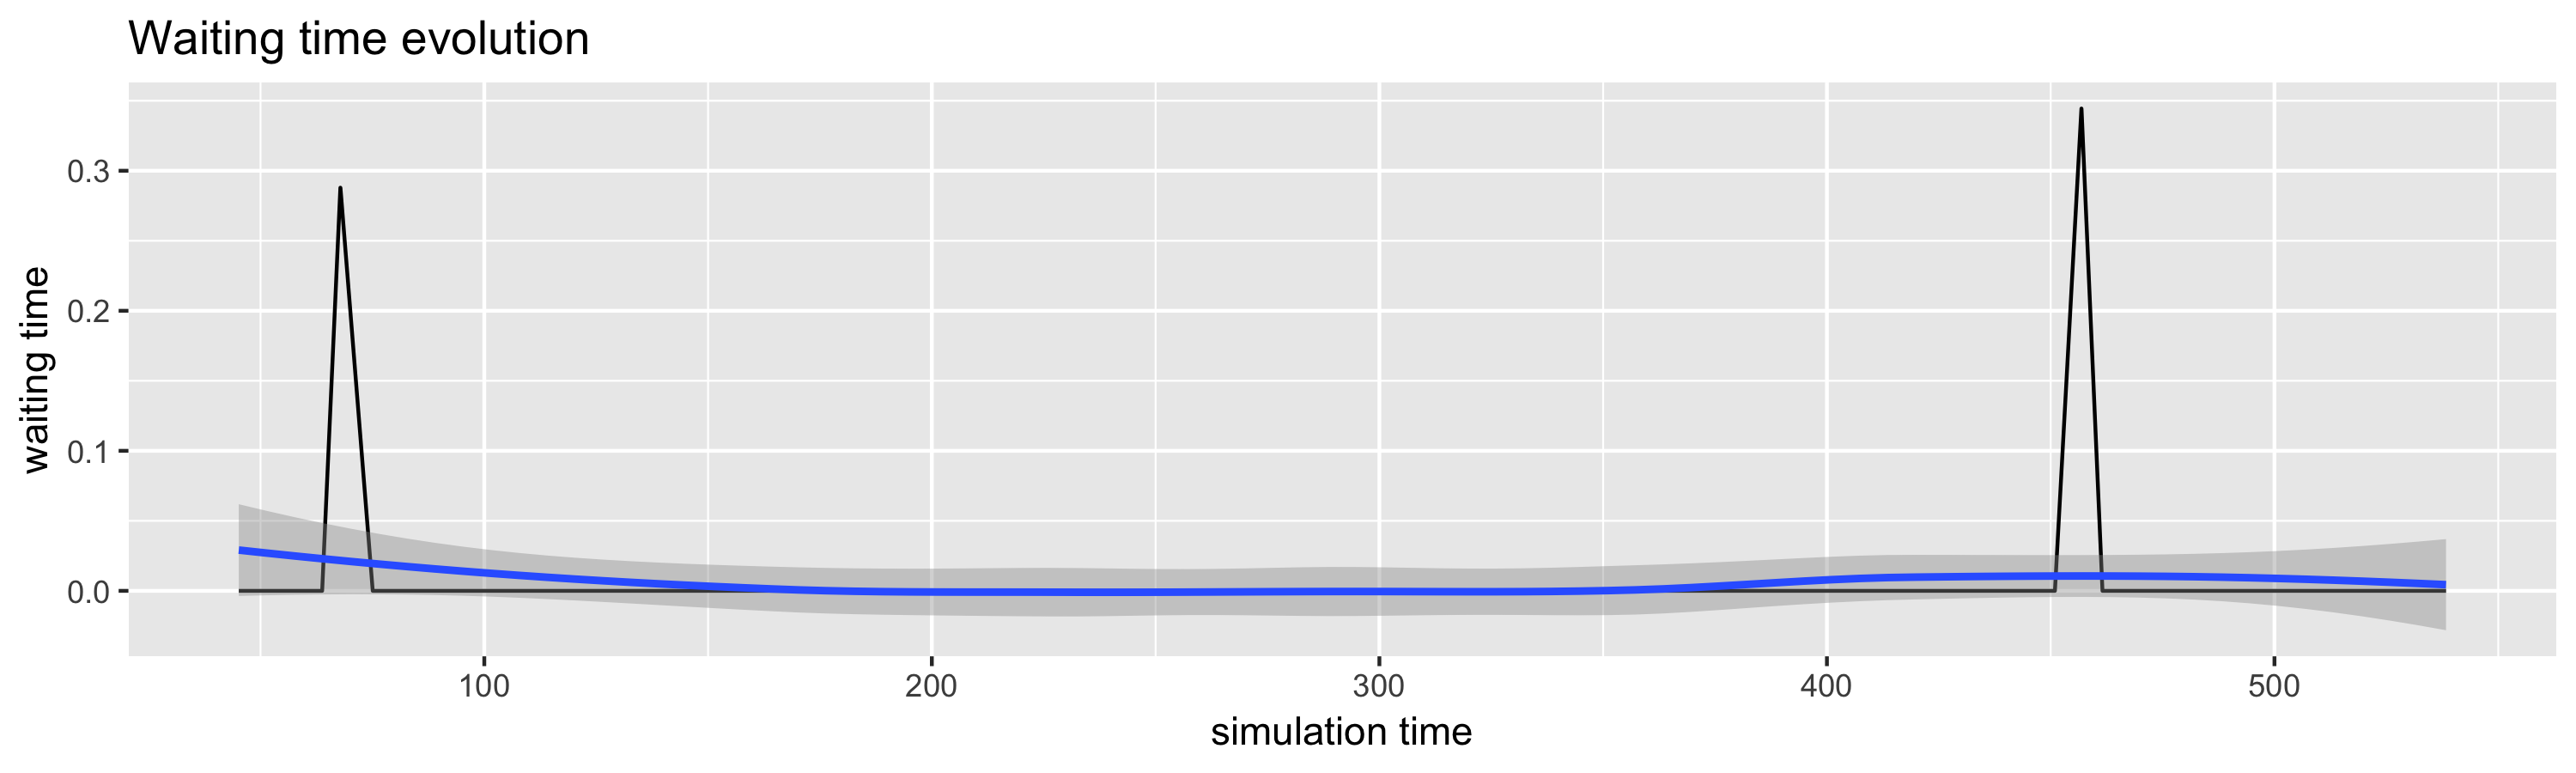

In [11]:

env4 <- simmer("clinic")

env4 %>%
  add_resource("nurse", 4) %>%    
  add_resource("doctor", 5) %>%     # DODALI SMO DOKTORA
  add_resource("administration", 2) %>%
  add_generator("patient", patient, function() rnorm(1, 5, 0.5)) %>%
  run(until=540)  # 540 minuta, 9 sati


env4_arrivals <- get_mon_arrivals(env4)
env4_resources <- get_mon_resources(env4)

plot(env4_resources, metric = "usage", c("nurse", "doctor", "administration"),
     items=c("queue", "server"))

plot(env4_resources, metric="utilization", c("nurse", "doctor", "administration"))

plot(env4_arrivals, metric = "waiting_time")
